In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import os

from pynestml.frontend.pynestml_frontend import generate_nest_target

NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func("statusdict/prefix ::")

<frozen importlib._bootstrap>:241: RuntimeWarning: compiletime version 3.8 of module 'pynestkernel' does not match runtime version 3.1
<frozen importlib._bootstrap>:241: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 880 from C header, got 888 from PyObject



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: master@61f08e0ea
 Built: Jul 14 2022 17:28:07

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
neuron_model = [
    "edlif_psc_percent.nestml",
    "iaf_psc_alpha"
]

# Choose noise type
noise = "poisson_generator" # noise_generator (gaussian) or poisson_generator
# more info here:
# https://nest-simulator.readthedocs.io/en/v2.18.0/models/generator.html#classnest_1_1ac__generator
exc_mean = 100 # mean value of noise current (pA). Only for Gaussian
exc_std = exc_mean/10
inh_mean = 100
inh_std = inh_mean/10
exc_rate = 80000 # Only for poisson
inh_rate = 80000

# weights
noise_exc_w = 2.*1
noise_inh_w = -1.*0

# sim time
sim_time = 1000

nest.Install("nestmlmodule")
nest.set_verbosity("M_WARNING")


Aug 22 16:56:10 Install [Info]: 
    loaded module nestmlmodule


In [3]:
def bombard_neuron(neuron_id):
    nest.ResetKernel()

    neuron_model_name = neuron_model[neuron_id].split(".")[0]
    print(f"Using neuron model: {neuron_model_name}")

    neuron = nest.Create(neuron_model_name)
    exc_noise = nest.Create(noise)
    inh_noise = nest.Create(noise)
    mult = nest.Create("multimeter", params={'record_from':['V_m']})
    sr = nest.Create('spike_recorder')

    if noise == "noise_generator":
        exc_noise.mean = exc_mean
        exc_noise.std = exc_std
        inh_noise.mean = inh_mean
        inh_noise.std = inh_std
    elif noise == "poisson_generator":
        exc_noise.rate = exc_rate  
        inh_noise.rate = inh_rate  
    
    # connections
    syn_dict_noise_exc = {"weight": noise_exc_w}
    syn_dict_noise_inh = {"weight": noise_inh_w}
    nest.Connect(exc_noise, neuron, syn_spec=syn_dict_noise_exc)
    nest.Connect(inh_noise, neuron, syn_spec=syn_dict_noise_inh)

    nest.Connect(mult, neuron)
    nest.Connect(neuron, sr)
    nest.Simulate(sim_time)

    vm = mult.get('events', 'V_m')
    spk_times = sr.get('events', 'times')
    return vm, spk_times 

In [4]:
def plot_vm(vm, s_times):
    plt.figure(figsize=(12, 6))
    #fig, ax = plt.subplots(nrows=2, figsize=(15,12))
    plt.plot(vm, label="voltage")
    spks = np.ones(len(s_times))*-50
    plt.plot(s_times, spks, 'o', color='orange', label="spike times")
    plt.xlabel('time')
    plt.ylabel('Voltage (mV)')
    plt.legend()

Using neuron model: edlif_psc_percent


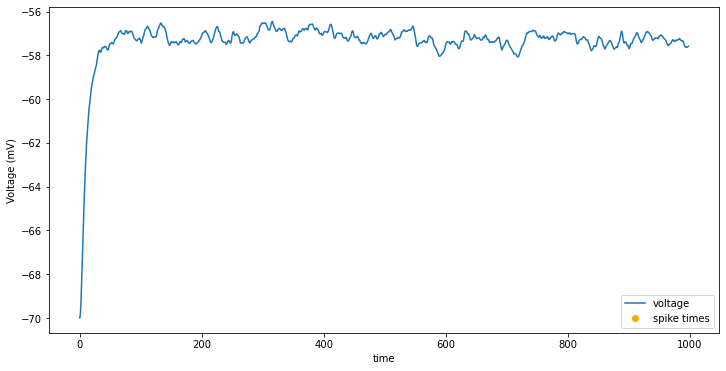

In [5]:
# Choose neuron model
neuron_id = 0 # edlif (0) or iaf (1)
vm, s_times = bombard_neuron(neuron_id)
plot_vm(vm, s_times)

Using neuron model: iaf_psc_alpha


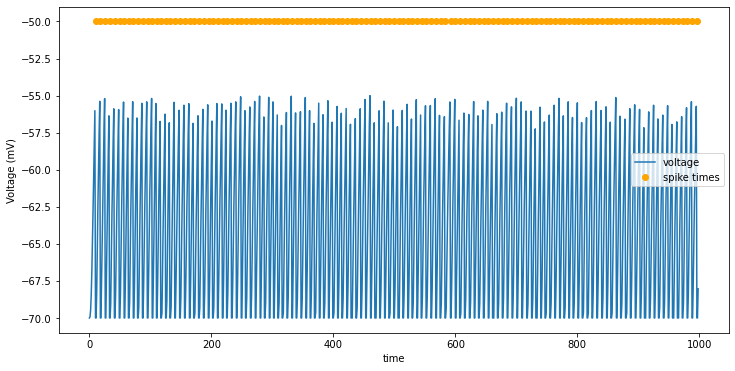

In [6]:
# Choose neuron model
neuron_id = 1 # edlif (0) or iaf (1)
vm, s_times = bombard_neuron(neuron_id)
plot_vm(vm, s_times)